# ST2195 Coursework question 5

### UOL Student Number 200549079

# Importing & Loading Necessary Packages 

In [1]:
import os
import sqlite3
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer #transform different types
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from math import sqrt

# Working Directory

In [2]:
# Input your own directory where the Harvard Dataverse files are located within the code below.
os.chdir("C:\\Users\\Sudharsaan\\OneDrive\\SIM\\Year 2\\ST2195 Programming for Data Science\\Coursework\\Essential Harvard Dataverse Files")
os.getcwd()

'C:\\Users\\Sudharsaan\\OneDrive\\SIM\\Year 2\\ST2195 Programming for Data Science\\Coursework\\Essential Harvard Dataverse Files'

# Establishing connection with airlinemain_py database

In [3]:
conn = sqlite3.connect("airlinemain_py.db")

In [4]:
c = conn.cursor()

# Performing Query on question 5 of coursework


Question 5 asks to use the available variables construct a model that predicts delays. Delays in the context of our model refers to the arrival delay. Thus, we will be building a model that predicts **arrival delay (target/response variable)** of flights that is based on data collected in 2006 & 2007. The **features** that will be chosen for bulding the model are:
- CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay, DepDelay, & AgeofPlane.

Take note that we remove cancelled & diverted flights from the dataset as rows of cancelled & diverted flights contain many null values in its features. This is due to the nature of cancelled & diverted flights. Furthermore, we aim to use age of plane as one of the features. In question 2, we queried for planes between ages 0 & 61 given the years the planes were manufactured & the latest year of flight in our dataset. Thus, when querying for age of planes as one of the features in our model, we once again restrict planes whose ages are below 0 & above 61 as they are considered erroneous data given the context of our analysis.

In [5]:
# Querying information that is required for building the model (i.e. Subsetting the dataset by its features & the target)
q5_dataset = c.execute('''
                          SELECT CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay, DepDelay, 
                          (ontime.Year - planes.year), ArrDelay
                          FROM ontime JOIN planes ON ontime.TailNum = planes.tailnum
                          WHERE Cancelled = 0 AND Diverted = 0 AND (ontime.Year - planes.year) > -1 AND 
                          (ontime.Year - planes.year) < 62''')
q5_dataset = pd.DataFrame(q5_dataset)
q5_dataset = q5_dataset.rename(columns = {0: "CarrierDelay", 1: "WeatherDelay", 2: "NASDelay", 3: "SecurityDelay", 
                                          4: "LateAircraftDelay", 5: "DepDelay", 6: "AgeofPlane", 7: "ArrDelay"})
q5_dataset

,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DepDelay,AgeofPlane,ArrDelay
0,0,0,0,0,0,-2.0,7,6.0
1,0,0,0,0,0,0.0,9,-23.0
2,0,0,0,0,0,-8.0,16,0.0
3,0,0,0,0,0,-3.0,6,2.0
4,0,0,0,0,0,-3.0,17,7.0
...,...,...,...,...,...,...,...,...
11564870,0,0,0,0,0,-7.0,15,13.0
11564871,0,0,0,0,0,11.0,7,5.0
11564872,0,0,15,0,0,-1.0,20,15.0
11564873,0,0,0,0,36,38.0,17,36.0


## Splitting into training & test datasets

In [6]:
features = ["CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay", "DepDelay", "AgeofPlane"]
X = q5_dataset[features].copy()
y = q5_dataset["ArrDelay"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

## Pipelines: Pre-processing stage

In [7]:
numerical_features = ["CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay", "DepDelay", 
                      "AgeofPlane"]

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())])

data_transformer = ColumnTransformer(
    transformers = [('numerical', numerical_transformer, numerical_features)])

## Setting parameters for hyper parameter tuning 

In [8]:
param_grid = {
    'data_transformer__numerical__imputer__strategy': ['mean', 'median', 'most_frequent']
}

## Creating Models to predict Arrival Delay

We will be creating **3 different models** to predict arrival delay & assessing which model is the best using various **metrics**. The models to be created are:
1. Linear Regression Model
2. Lasso Regression Model
3. Ridge Regression Model

### Linear Regression Model

In [ ]:
pipe_lm = Pipeline(steps=[('data_transformer', data_transformer),
                          ('pipe_lm', LinearRegression())])

grid_lm = GridSearchCV(pipe_lm, param_grid=param_grid, n_jobs = -1) 
grid_lm.fit(X_train, y_train);

In [10]:
y_predict_lm = grid_lm.predict(X_test)

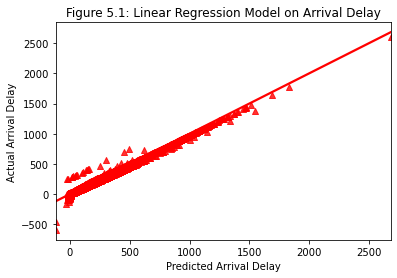

In [11]:
sns.regplot(x=y_predict_lm, y=y_test, color='red', marker="^")
plt.xlabel("Predicted Arrival Delay")
plt.ylabel("Actual Arrival Delay")
plt.title("Figure 5.1: Linear Regression Model on Arrival Delay")
plt.show()

In [12]:
grid_lm.best_score_

0.9500514233102522

In [13]:
grid_lm.best_params_

{'data_transformer__numerical__imputer__strategy': 'median'}

In [14]:
RMSE = np.sqrt(mean_squared_error(y_test, y_predict_lm)) # Calculating Root Mean Squared Error (RMSE)
MSE = mean_squared_error(y_test, y_predict_lm) # Calculating Mean Squared Error (MSE)
MAE = mean_absolute_error(y_test, y_predict_lm) # Calculating Mean Absolute Error (MAE)
r2 = r2_score(y_test, y_predict_lm) # Calculating R-Squared (ranges between 0 & 1 - The higher the value, the better the model)

Metrics_lm = [RMSE, MSE, MAE, r2]
Metrics_lm = pd.DataFrame(Metrics_lm)
Metrics_lm.index = ["RMSE", "MSE", "MAE", "r2"]
Metrics_lm.columns = ["Linear"]
Metrics_lm

,Linear
RMSE,8.506990
MSE,72.368877
MAE,6.508281
r2,0.950125


### Lasso Regression Model

In [ ]:
pipe_ls = Pipeline(steps=[('data_transformer', data_transformer),
                          ('pipe_ls', Lasso(random_state = 1))])

grid_ls = GridSearchCV(pipe_ls, param_grid = param_grid, n_jobs = -1) 
grid_ls.fit(X_train, y_train);

In [16]:
y_predict_ls = grid_ls.predict(X_test)

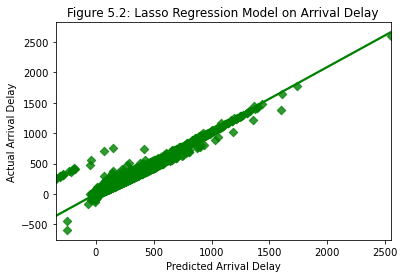

In [17]:
sns.regplot(x=y_predict_ls, y=y_test, color='green', marker="D")
plt.xlabel("Predicted Arrival Delay")
plt.ylabel("Actual Arrival Delay")
plt.title("Figure 5.2: Lasso Regression Model on Arrival Delay")
plt.show()

In [18]:
grid_ls.best_score_

0.9429952910886961

In [19]:
grid_ls.best_params_

{'data_transformer__numerical__imputer__strategy': 'median'}

In [20]:
RMSE = np.sqrt(mean_squared_error(y_test, y_predict_ls)) # Calculating Root Mean Squared Error (RMSE)
MSE = mean_squared_error(y_test, y_predict_ls) # Calculating Mean Squared Error (MSE)
MAE = mean_absolute_error(y_test, y_predict_ls) # Calculating Mean Absolute Error (MAE)
r2 = r2_score(y_test, y_predict_ls) # Calculating R-Squared (ranges between 0 & 1 - The higher the value, the better the model)

Metrics_ls = [RMSE, MSE, MAE, r2]
Metrics_ls = pd.DataFrame(Metrics_ls)
Metrics_ls.index = ["RMSE", "MSE", "MAE", "r2"]
Metrics_ls.columns = ["Lasso"]
Metrics_ls

,Lasso
RMSE,9.114436
MSE,83.072949
MAE,6.952331
r2,0.942748


### Ridge Regression Model

In [ ]:
pipe_rr = Pipeline(steps=[('data_transformer', data_transformer),
                           ('pipe_rr', Ridge(solver = 'saga', random_state = 1))])
                           
grid_rr = GridSearchCV(pipe_rr, param_grid = param_grid, n_jobs = -1)  
grid_rr.fit(X_train, y_train);

In [22]:
y_predict_rr = grid_rr.predict(X_test)

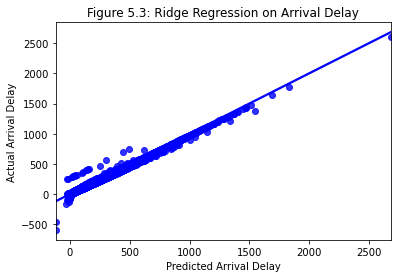

In [23]:
sns.regplot(x=y_predict_rr, y=y_test, color='blue', marker = "o")
plt.xlabel("Predicted Arrival Delay")
plt.ylabel("Actual Arrival Delay")
plt.title("Figure 5.3: Ridge Regression on Arrival Delay")
plt.show()

In [24]:
grid_rr.best_score_

nan

In [25]:
grid_rr.best_params_

{'data_transformer__numerical__imputer__strategy': 'mean'}

In [26]:
RMSE = np.sqrt(mean_squared_error(y_test, y_predict_rr)) # Calculating Root Mean Squared Error (RMSE)
MSE = mean_squared_error(y_test, y_predict_rr) # Calculating Mean Squared Error (MSE)
MAE = mean_absolute_error(y_test, y_predict_rr) # Calculating Mean Absolute Error (MAE)
r2 = r2_score(y_test, y_predict_rr) # Calculating R-Squared (ranges between 0 & 1 - The higher the value, the better the model)

Metrics_rr = [RMSE, MSE, MAE, r2]
Metrics_rr = pd.DataFrame(Metrics_rr)
Metrics_rr.index = ["RMSE", "MSE", "MAE", "r2"]
Metrics_rr.columns = ["Ridge"]
Metrics_rr

,Ridge
RMSE,8.507020
MSE,72.369390
MAE,6.508326
r2,0.950125


In [27]:
Metrics_compare = pd.concat([Metrics_lm, Metrics_ls, Metrics_rr], axis = 1)
Metrics_compare

,Linear,Lasso,Ridge
RMSE,8.506990,9.114436,8.507020
MSE,72.368877,83.072949,72.369390
MAE,6.508281,6.952331,6.508326
r2,0.950125,0.942748,0.950125


**Observations from table above**

The table above shows the metrics used to evaluate the performance of the 3 models that we have constructed to predict arrival delays. The lower the Root Mean Square Error (RMSE), Mean Squared Error (MSE), & the Mean Absolute Error (MAE), the better the model is at being able to predict arrival delays. The higher the R Squared value (r2), the better the model is at being able to predict arrival delays. 

# Conclusion

Thus, based on the R Squared values above, Linear & Ridge regression models are the best models in predicting arrival delays. However, since Ridge regression model has higher RMSE, MSE, & MAE values compared to the Linear regression model, **Linear regression model** is the **best model** in predicting arrival delay. 